<a href="https://colab.research.google.com/github/OscarBedford/MLCourse_Weekly_Exercises/blob/main/Exercise_7_7_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Dataset with brain atlas B: use the Oasis dataset to predict a continuous outcome (subject’s age) from structural brain scans.

*Note: use Ridge() instead of LogisticRegression() to predict the continuous subject age using the lowest-resolution version of Craddock region atlas (.scorr_mean), and use the R2 coefficient of determination instead of classification accuracy (sklearn.metrics.r2_score).*

``Task 7.7:`` analogous to ``Task 2``

In [ ]:
%%capture
!pip install nilearn

In [ ]:
%%capture
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib

In [ ]:
%%capture
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.model_selection import cross_val_score

In [ ]:
# We prepare the model with the required parameters 
logreg = Ridge()

# We prepare the inner iterating variable 
k_list = list(range(1,6))

In [ ]:
# We define the outer iterating variable
versions = list(range(1,43))

In [ ]:
# We pre-allocate the variables to store the scores
kMM_scores = []
gmm_scores = []
pca_scores = []
ica_scores = []

In [ ]:
%%capture
for x in versions:
    brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
    crad = datasets.fetch_atlas_craddock_2012()
    atlas_nii = index_img(crad['scorr_mean'], (x)) # We iterate through all atlases
    masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] # gives subject age on standard units after z-scoring

    for i in k_list:
          X, y = input_variables, output_variable
          X = scaler.fit_transform(X)

          kMM = KMeans(n_clusters=i).fit(X)
          X_kMM = kMM.transform(X)
          scores1 = cross_val_score(logreg, X_kMM, y, cv=5)
          kMM_scores.append(scores1) # We store the scores

          gmm = GaussianMixture(n_components=i).fit(X)
          gmm_X = gmm.predict_proba(X)      
          scores2 = cross_val_score(logreg, gmm_X, y, cv=5)
          gmm_scores.append(scores2) # We store the scores

          pca = PCA(n_components=i).fit(X)
          X_pca = pca.transform(X)
          scores3 = cross_val_score(logreg, X_pca, y, cv=5)
          pca_scores.append(scores3) # We store the scores

          ica = FastICA(n_components=i,tol=0.01).fit(X)
          X_ica = ica.transform(X)
          scores4 = cross_val_score(logreg, X_ica, y, cv=5)
          ica_scores.append(scores4) # We store the scores

In [ ]:
n = 5
np_kMM_scores = np.array(kMM_scores)
fold_avg_kMM = np.average(np_kMM_scores.reshape(-1, n), axis=1)
comp_avg_kMM = np.average(fold_avg_kMM.reshape(-1, n), axis=1)

np_gmm_scores = np.array(gmm_scores)
fold_avg_gmm = np.average(np_gmm_scores.reshape(-1, n), axis=1)
comp_avg_gmm = np.average(fold_avg_gmm.reshape(-1, n), axis=1)

np_pca_scores = np.array(pca_scores)
fold_avg_pca = np.average(np_pca_scores.reshape(-1, n), axis=1)
comp_avg_pca = np.average(fold_avg_pca.reshape(-1, n), axis=1)

np_ica_scores = np.array(ica_scores)
fold_avg_ica = np.average(np_ica_scores.reshape(-1, n), axis=1)
comp_avg_ica = np.average(fold_avg_ica.reshape(-1, n), axis=1)

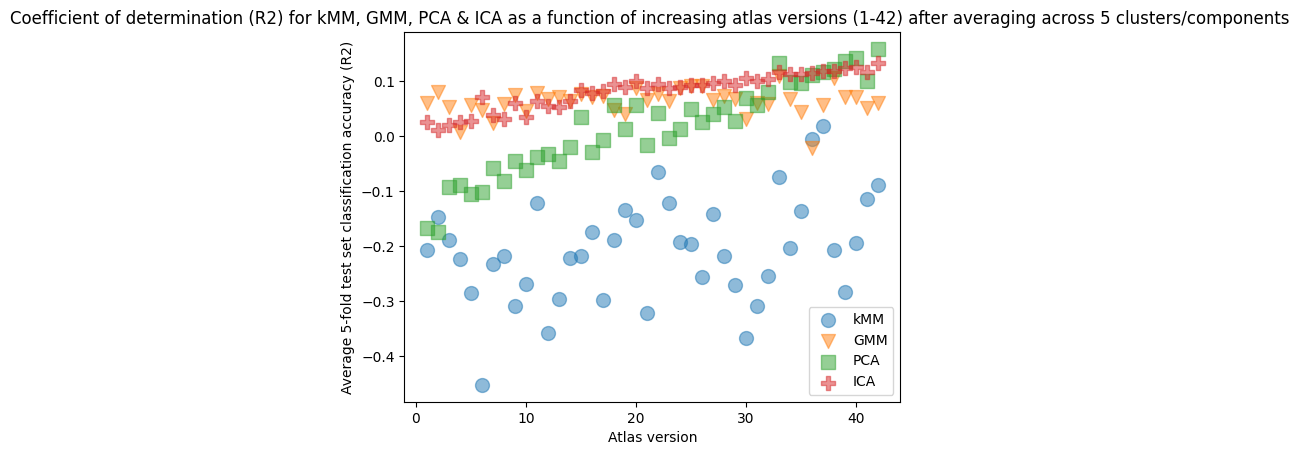

In [ ]:
lab = ['kMM', 'GMM', 'PCA', 'ICA']
plt.style.use("default")
plt.scatter(versions,comp_avg_kMM, s=100, alpha = 0.5, marker= "o",)
plt.scatter(versions,comp_avg_gmm, s=100, alpha = 0.5, marker= "v")
plt.scatter(versions,comp_avg_pca, s=100, alpha = 0.5, marker= "s")
plt.scatter(versions,comp_avg_ica, s=100, alpha = 0.5, marker= "P")
plt.legend(labels=(lab))
plt.gca().set(
    title="Coefficient of determination (R2) for kMM, GMM, PCA & ICA as a function of increasing atlas versions (1-42) after averaging across 5 clusters/components ",
    xlabel="Atlas version",
    ylabel="Average 5-fold test set classification accuracy (R2)",
)
plt.show()